In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

# Đọc dữ liệu
df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col='Date')

# Chọn cột giá cần dự đoán (giả sử là 'Close')
data = df['Close']

ADF Statistic: -0.9724609214136788
p-value: 0.7631755854868321
ADF Statistic after differencing: -10.847695422105879
p-value after differencing: 1.5571881406329142e-19


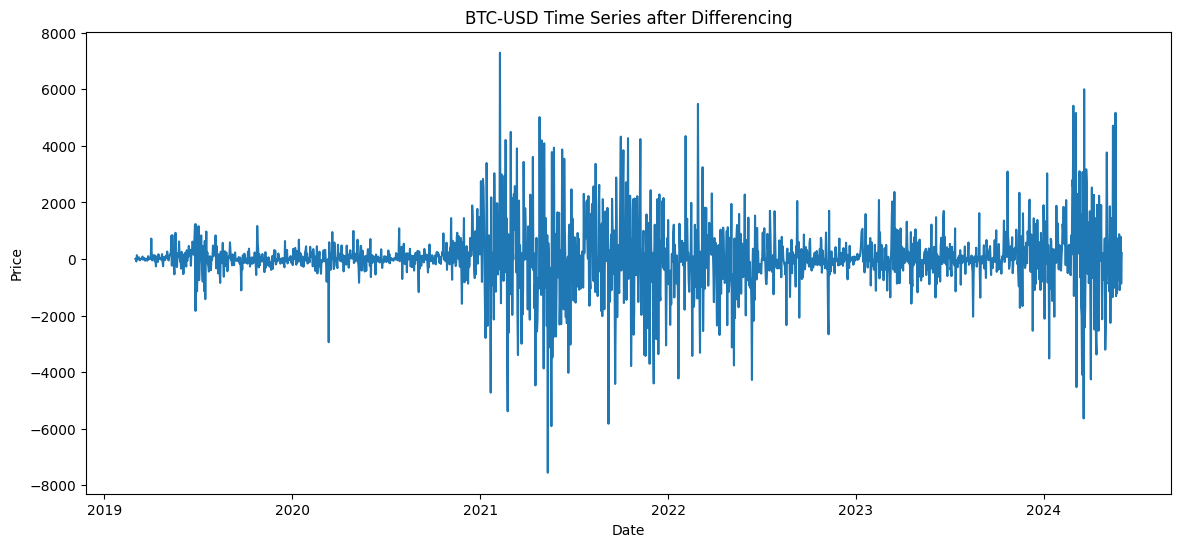

In [15]:
# Kiểm tra tính dừng của chuỗi thời gian
adf_result = adfuller(data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Nếu chuỗi không dừng, thực hiện khác biệt hóa
if adf_result[1] > 0.05:
    data_diff = data.diff().dropna()
    adf_result_diff = adfuller(data_diff)
    print(f"ADF Statistic after differencing: {adf_result_diff[0]}")
    print(f"p-value after differencing: {adf_result_diff[1]}")
else:
    data_diff = data

# Vẽ đồ thị chuỗi thời gian sau khi khác biệt hóa (nếu cần)
plt.figure(figsize=(14, 6))
plt.plot(data_diff)
plt.title('BTC-USD Time Series after Differencing')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [16]:
# Chia dữ liệu: 70% train, 30% test
train_size = int(len(data_diff) * 0.70)
train_data = data_diff.iloc[:train_size]
test_data = data_diff.iloc[train_size:]

In [17]:
# Định nghĩa phạm vi tìm kiếm cho Grid Search
p = d = q = range(0, 3)  # Định nghĩa phạm vi cho các tham số (p, d, q)
P = D = Q = range(0, 2)  # Định nghĩa phạm vi cho các tham số mùa vụ (P, D, Q)
s = [12]  # Kỳ mùa vụ (thường là 12 cho dữ liệu hàng tháng)

# Tạo tất cả các tổ hợp có thể có của các tham số ARIMA
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Thử tất cả các tổ hợp có thể có
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            sarima_fit = model.fit(disp=False)

            if sarima_fit.aic < best_aic:
                best_aic = sarima_fit.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = sarima_fit
        except:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq}12 with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best SARIMA model: (0, 1, 2) x (1, 1, 1, 12)12 with AIC: 22341.231139445805


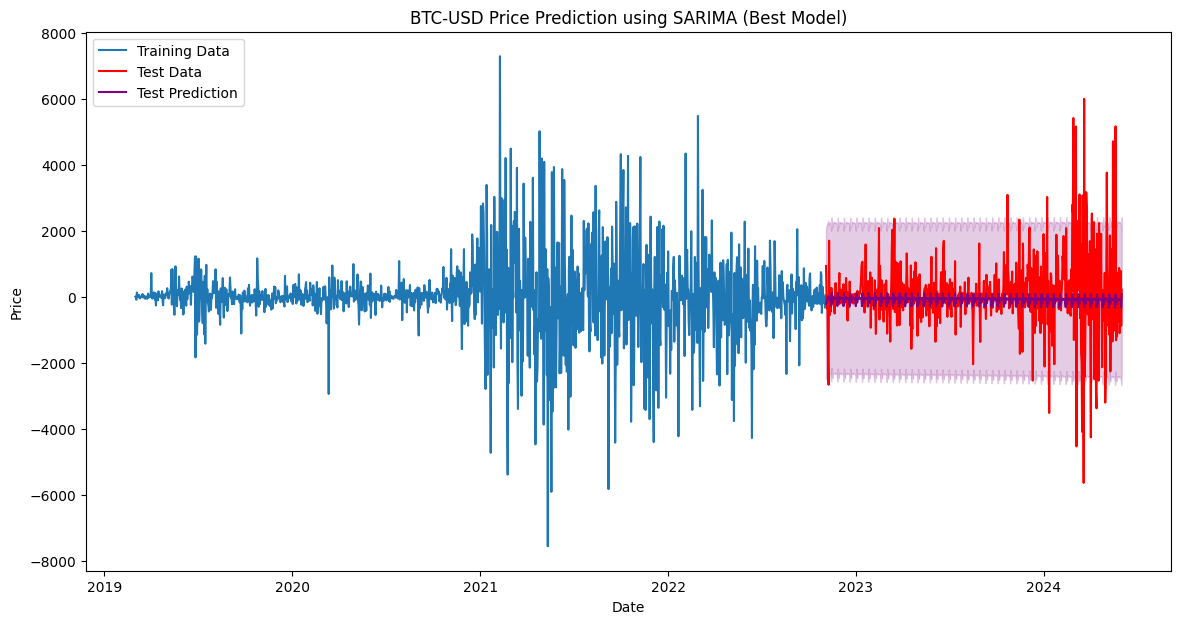

In [18]:
# Sử dụng mô hình tốt nhất để dự đoán trên tập test
test_pred = best_model.get_prediction(start=test_data.index[0], end=test_data.index[-1])
test_pred_mean = test_pred.predicted_mean
test_conf_int = test_pred.conf_int()

# Hiển thị kết quả
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')

# Dự đoán cho tập test
plt.plot(test_pred_mean, label='Test Prediction', color='purple')
plt.fill_between(test_conf_int.index, test_conf_int.iloc[:, 0], test_conf_int.iloc[:, 1], color='purple', alpha=0.2)

plt.title('BTC-USD Price Prediction using SARIMA (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
# Đánh giá mô hình bằng RMSE
mse = ((test_pred_mean - test_data) ** 2).mean() # Use test_pred_mean and test_data
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 1115.561003473851


In [3]:
# Kiểm tra tính dừng của chuỗi thời gian
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Nếu chuỗi không dừng, thực hiện khác biệt hóa
if adf_result[1] > 0.05:
    train_data_diff = train_data.diff().dropna()
    adf_result_diff = adfuller(train_data_diff)
    print(f"ADF Statistic after differencing: {adf_result_diff[0]}")
    print(f"p-value after differencing: {adf_result_diff[1]}")
else:
    train_data_diff = train_data

# Vẽ đồ thị ACF và PACF sau khi khác biệt hóa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

plot_acf(train_data_diff, ax=ax1)
ax1.set_title('ACF after Differencing')

plot_pacf(train_data_diff, ax=ax2, method='ywm')
ax2.set_title('PACF after Differencing')

plt.tight_layout()
plt.show()



NameError: name 'train_data' is not defined

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 1344
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood              -11406.122
Date:                              Fri, 14 Jun 2024   AIC                          22826.243
Time:                                      19:08:37   BIC                          22862.599
Sample:                                  03-01-2019   HQIC                         22839.868
                                       - 11-03-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0215      1.981      0.011      0.991      -3.861       3.904
ar.L2          0.97

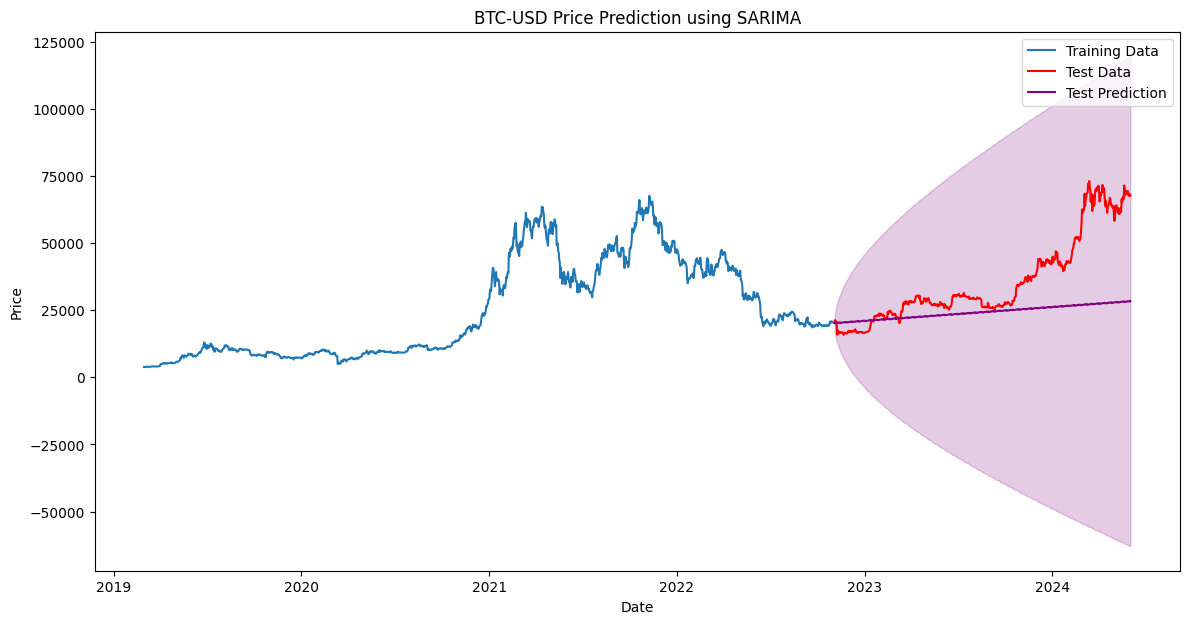

In [ ]:
# Huấn luyện mô hình SARIMA
# Giả sử chọn các tham số (p, d, q) = (2, 1, 2) và (P, D, Q, s) = (1, 1, 1, 12)
model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)
print(sarima_fit.summary())

# Dự đoán trên tập test
test_pred = sarima_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1])
test_pred_mean = test_pred.predicted_mean
test_conf_int = test_pred.conf_int()

# Vẽ đồ thị kết quả dự đoán theo thứ tự: train -> test
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')

# Dự đoán cho tập test
plt.plot(test_pred_mean, label='Test Prediction', color='purple')
plt.fill_between(test_conf_int.index, test_conf_int.iloc[:, 0], test_conf_int.iloc[:, 1], color='purple', alpha=0.2)

plt.title('BTC-USD Price Prediction using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [ ]:
# Đánh giá mô hình
test_rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
print(f"Test RMSE: {test_rmse}")